In [1]:
import sys
sys.path.append('../')

In [2]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 

from main import *

np.random.seed(0)

Our variational approach finds the minimum energy of the quantum system in the first quantization. In this notebook, we show this by simulating the unidimensional hydrogen atom, whose Hamiltonian is given by
$$ H = \frac{1}{2}\left( P^2 - \frac{1}{|X|} \right).$$
The first term corresponds to the electron's kinetic energy, and the second one is the potential for attraction between the electron and the nucleus due to Coulomb law.

In [3]:
num_wires = 5
dev = qml.device( "lightning.qubit", 
                    wires=2*num_wires ) 

In [4]:
xrange = 20
X, P = X_and_P_ops( range(num_wires), -xrange, xrange )  
H = [ P.pow(2).s_prod(0.5),
        X.abs().pow(-1).s_prod(-0.5)]
H

[<Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4]>]

In [5]:
H_matrix = tomatrix( H )
vals, vecs = np.linalg.eigh( H_matrix )
vecs = [vec for vec in vecs.T]

The eigenstates of the hydrogen atom are symmetric or antisymmetric, so we employ variational circuits with those properties. Partecularly, the ground state is symetric, so we symetrice our variationa circuit with the function ```symmetric_ansatz```.

In [6]:
num_layers = 1
# 1 qubit is added at symmetrization
base_ansatz = ZGR_ansatz(num_wires-1, num_layers)
ansatz_sym = symmetric_ansatz(base_ansatz=base_ansatz)

var_state = ansatz_sym.construct_circuit
num_params = ansatz_sym.num_params

(<Figure size 3900x600 with 1 Axes>, <Axes: >)

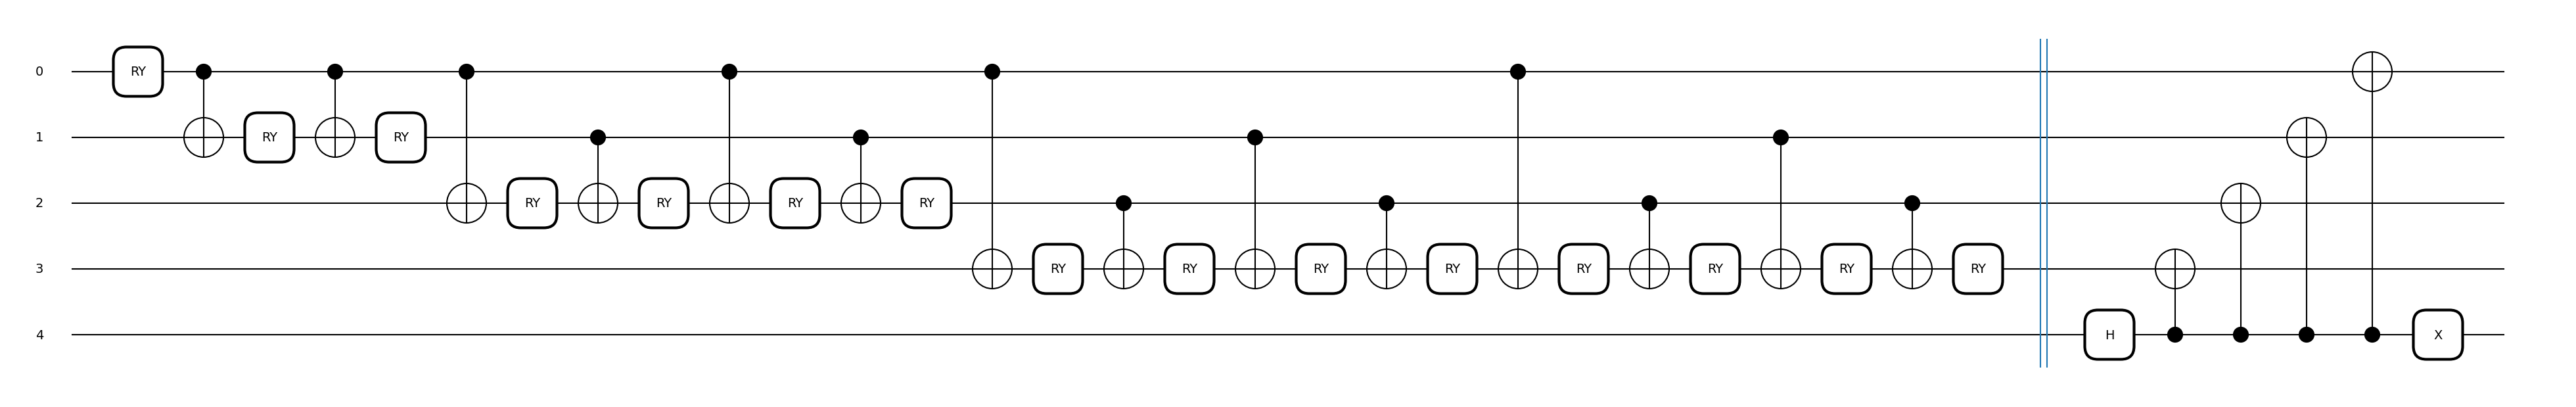

In [7]:
qml.draw_mpl( var_state, wire_order=range(num_wires))( num_params*[0] )

In [8]:
device = qml.device("lightning.qubit", 
                    wires=num_wires)

varqft = VarFourier( H,
                    device,
                    var_state = var_state)

In [9]:
params_init = 1e-3 * np.random.randn( num_params )

params_ground, energies_ground = varqft.run(params_init,
                                            max_iterations=300,
                                            learning_rate=0.1,
                                            conv_tol=1e-6)

print(f'Optimal energy: {vals[0]:.6f}')

Step:    153, Energy:    -0.567446
Optimal energy: -0.567537


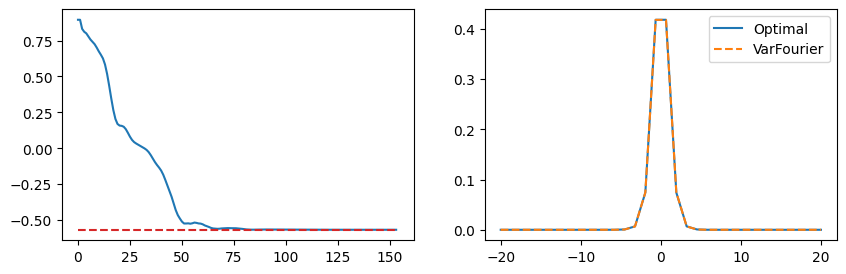

In [10]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot(energies_ground)
ax[0].hlines(vals[0], 0, len(energies_ground), colors='tab:red', linestyles='--') 

ground_state = varqft.state( params_ground[-1] )

ax[1].plot( X.eigvals(), np.abs(vecs[0])**2) 
ax[1].plot( X.eigvals(), np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 

The fidelity of our solution is:

In [11]:
fidelity = abs(np.vdot(ground_state, vecs[0]))**2
fidelity

0.9998875323276094

Now, we are going to find the first excited state. This state is antisymmetric, so we antisymmetric our variation circuit setting the input ```antisymmetric=True``` in the ```symmetric_ansatz``` function. We update the variationa circuit on the `varqft` with the `VarFourier.set_var_state` function. Moreover, we include Langrange's multipliers in our optimization in order to optimice in the subspace orthogonal to the ground state. This is done with the function `VarFourier.set_ortho`.

In [12]:
ansatz_antisym = symmetric_ansatz(ZGR_ansatz(num_wires-1, num_layers),
                                    antisymmetric=True)

ortho_values = [ 25 ]
ortho_params = [ np.copy(params_ground[-1]) ]
ortho_circuits = [ ansatz_sym.construct_circuit ]

varqft.set_var_state(ansatz_antisym.construct_circuit)

varqft.set_ortho(values = ortho_values,
                    params = ortho_params,
                    circuits = ortho_circuits)

In [15]:
params_init_ex = 1e-3 * np.random.randn(num_params)

params_excited, energies_excited = varqft.run(params_ground[-1],
                                                max_iterations=500,
                                                learning_rate= 0.1,
                                                conv_tol=1e-6)

print(f'Optimal energy: {vals[1]:.6f}')

Step:    241, Energy:    -0.134486
Optimal energy: -0.134796


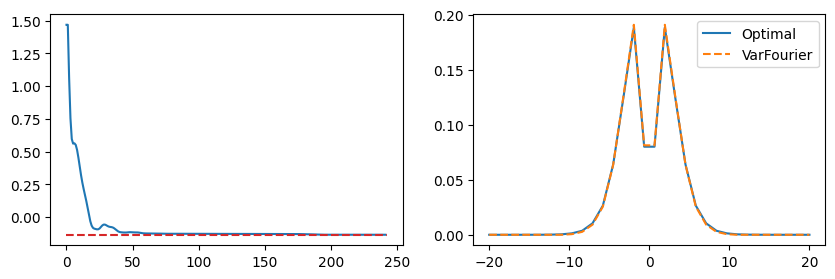

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,3) ) 

ax[0].plot(energies_excited)
ax[0].hlines(vals[1], 0, len(energies_excited), 
                colors='tab:red', linestyles='--' ) 

excited_state = varqft.state(params_excited[-1])

ax[1].plot(X.eigvals(), np.abs(vecs[1])**2) 
ax[1].plot(X.eigvals(), np.abs(excited_state)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 

In [17]:
fidelity = abs(np.vdot(excited_state, vecs[1]))**2
fidelity

0.9982445839713411

The second excited state is symmetric. Working simmilar than before.

In [18]:
varqft.add_ortho(values = [25],
                    params = [params_excited[-1]],
                    circuits = [ansatz_antisym.construct_circuit])

varqft.set_var_state(ansatz_sym.construct_circuit)

In [19]:
params_init_ex2 = 1e-3 * np.random.randn( num_params )

In [21]:
# params_init_ex2 = 1e-3 * np.random.randn( num_params )

params_excited2, energies_excited2 = varqft.run(params_init_ex2,
                                                max_iterations=300,
                                                learning_rate=0.1,
                                                conv_tol=1e-5)

print(f'Optimal energy: {vals[2]:.6f}')

Step:    300, Energy:    -0.053626
Optimal energy: -0.055135


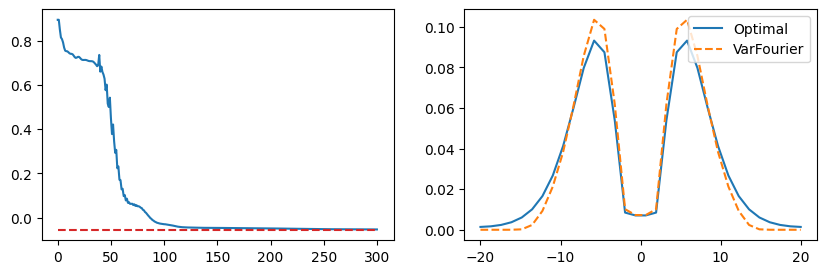

In [22]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot(energies_excited2)
ax[0].hlines(vals[2], 0, len(energies_excited2), colors='tab:red', linestyles='--' ) 

excited_state2 = varqft.state( params_excited2[-1] )


ax[1].plot(X.eigvals(), np.abs(vecs[2])**2) 
ax[1].plot(X.eigvals(), np.abs(excited_state2)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 

In [23]:
fidelity = abs(np.vdot(excited_state2, vecs[2]))**2
fidelity

0.964164757199514

Analogously for the third-excited state, which is antisymmetric.

In [24]:
varqft.add_ortho(values = [25],
                    params = [params_excited2[-1]],
                    circuits = [ansatz_sym.construct_circuit])

varqft.set_var_state(ansatz_antisym.construct_circuit)

In [25]:
params_init_ex3 = 1e-3 * np.random.randn( num_params )

params_excited3, energies_excited3 = varqft.run(params_init_ex3,
                                                max_iterations=300,
                                                learning_rate=0.1,
                                                conv_tol=1e-6)

print(f'Optimal energy: {vals[3]:.6f}')

Step:    259, Energy:    -0.030442
Optimal energy: -0.030304


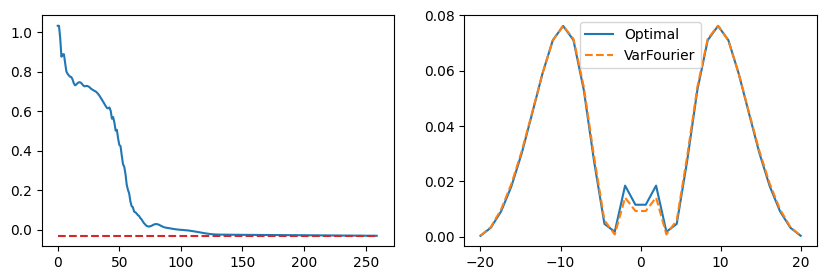

In [26]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot(energies_excited3)
ax[0].hlines(vals[3], 0, len(energies_excited3), colors='tab:red', linestyles='--' ) 

excited_state3 = varqft.state( params_excited3[-1] )

ax[1].plot( X.eigvals(), np.abs(vecs[3])**2) 
ax[1].plot( X.eigvals(), np.abs(excited_state3)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 

In [27]:
fidelity = abs(np.vdot(excited_state3, vecs[3]))**2
fidelity

0.9985304825038269

Analogously for the fourth-excited state, which is symmetric.

In [28]:
varqft.add_ortho(values = [25],
                    params = [params_excited3[-1]],
                    circuits = [ansatz_antisym.construct_circuit])

varqft.set_var_state(ansatz_sym.construct_circuit)

In [29]:
params_init_ex4 = 1e-3 * np.random.randn(num_params)

params_excited4, energies_excited4 = varqft.run(params_init_ex4,
                                                max_iterations=300,
                                                learning_rate=0.1,
                                                conv_tol=1e-5)

print(f'Optimal energy: {vals[4]:.6f}')

Step:    300, Energy:    -0.022984
Optimal energy: -0.022069


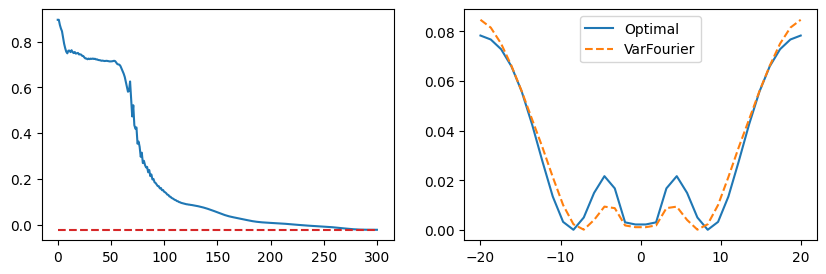

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10,3)) 

ax[0].plot( energies_excited4 )
ax[0].hlines( vals[4], 0, len(energies_excited4), colors='tab:red', linestyles='--' ) 

excited_state4 = varqft.state( params_excited4[-1] )

ax[1].plot( X.eigvals(), np.abs(vecs[4])**2) 
ax[1].plot( X.eigvals(), np.abs(excited_state4)**2, '--') 
ax[1].legend(['Optimal','VarFourier']) 

In [31]:
fidelity = abs(np.vdot(excited_state4, vecs[4]))**2
fidelity

0.9651208253284165

Plotting the energies from the ground state to the fourth-excited state, we see the well-known quadratic scaling of the energies of the hydrogen atom.

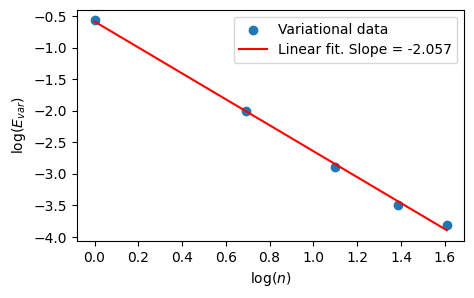

Pendiente = -2.0565392436675207


In [54]:

fig, ax = plt.subplots(1, 1, figsize=(5,3)) 

x = np.log(np.arange(1,6))
y = np.log(np.abs(vals[0:5]))
ax.scatter(x , y, label = 'Variational data')

slope, intercept = np.polyfit(x, y, 1)
y_fit = slope * x + intercept
plt.plot(x, y_fit, color='red', label=f'Linear fit. Slope = {slope:3.3f}')

plt.xlabel(r'$\log(n)$')
plt.ylabel(r'$\log(E_{var})$')

plt.legend()
plt.savefig('../figures/Hydrogen_atom_energies.png')
plt.show()

print(f'Pendiente = {slope}')

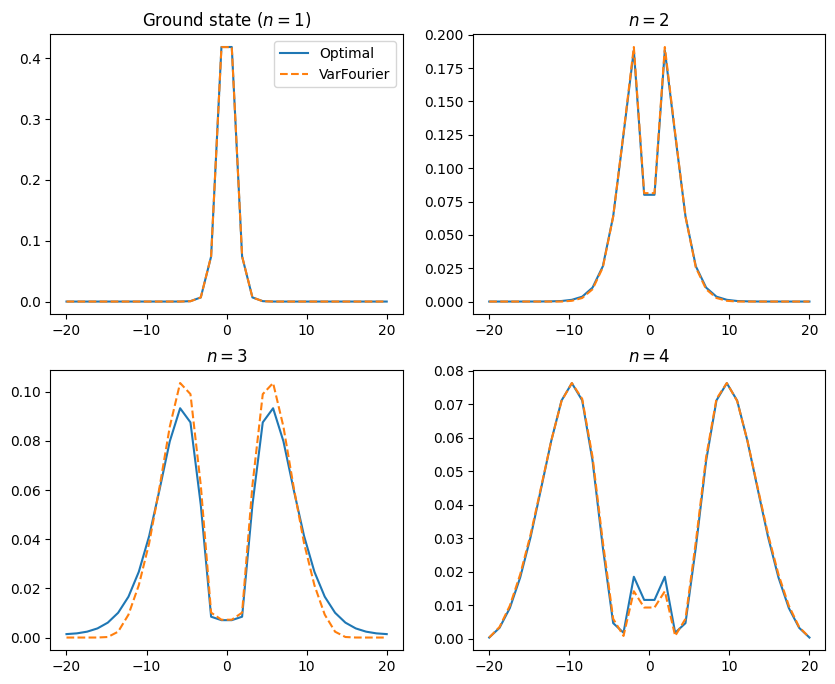

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(10,8)) 

x = X.eigvals()
ground_state = varqft.state( params_ground[-1] )

ax[0,0].plot(x, np.abs(vecs[0])**2 ) 
ax[0,0].plot(x, np.abs(ground_state)**2, '--' ) 
ax[0,0].legend(['Optimal','VarFourier']) 
ax[0,0].set_title('Ground state ($n=1$)')

ax[0,1].plot(x, np.abs(vecs[1])**2) 
ax[0,1].plot(x, np.abs(excited_state)**2, '--' )
ax[0,1].set_title('$n=2$')

ax[1,0].plot(x, np.abs(vecs[2])**2) 
ax[1,0].plot(x, np.abs(excited_state2)**2, '--' ) 
ax[1,0].set_title('$n=3$')

ax[1,1].plot(x, np.abs(vecs[3])**2) 
ax[1,1].plot(x, np.abs(excited_state3)**2, '--' ) 
ax[1,1].set_title('$n=4$')

plt.savefig('../figures/Hydrogen_atom_first4states.png')
plt.show()

In [49]:
# np.save( 'data_H_atom', np.array([ x, vals, vecs[:4], ground_state, excited_state, excited_state2, excited_state3 ], dtype=object)  ) 

In [53]:
# x, vals, vecs, ground_state, excited_state, excited_state2, excited_state3 = np.load( 'data_H_atom.npy', allow_pickle=True )